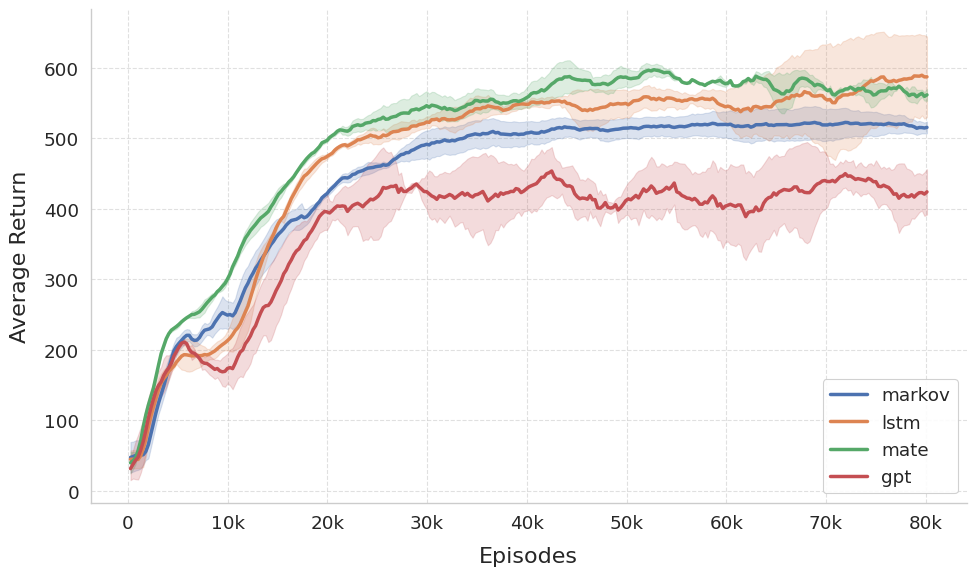

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------------------------------------
# 1. 가상의 데이터 생성 (사용자 환경에서는 이 부분은 건너뛰고 본인의 CSV를 사용하세요)
# -----------------------------------------------------------
def create_dummy_data():
    methods = ['Proposed Method', 'Baseline A', 'Baseline B', 'Ablation']
    seeds = [1, 2, 3]
    steps = np.arange(0, 100000, 1000) # 0부터 10만 스텝까지
    
    os.makedirs('rl_results', exist_ok=True)
    
    for method in methods:
        for seed in seeds:
            # 가상의 학습 곡선 생성 (로그 함수 + 노이즈)
            base_performance = np.log(steps + 100) * (methods.index(method) * -2 + 15)
            noise = np.random.normal(0, 5, size=len(steps))
            returns = base_performance + noise
            
            # DataFrame 생성
            df = pd.DataFrame({'Step': steps, 'Return': returns})
            
            # 파일 저장 (예: rl_results/Proposed Method_seed1.csv)
            filename = f"rl_results/{method}_seed{seed}.csv"
            df.to_csv(filename, index=False)
            
# create_dummy_data()
# print("가상 데이터 생성 완료.")

# -----------------------------------------------------------
# 2. 데이터 로드 및 전처리 (Smoothing 포함)
# -----------------------------------------------------------
def smooth(scalars, weight=0.9):
    """
    Tensorboard 스타일의 스무딩 함수
    weight: 0~1 사이 값. 1에 가까울수록 더 부드러워짐
    """
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return np.array(smoothed)

def load_data(data_dir):
    all_data = []
    
    # 디렉토리 내의 모든 csv 파일을 읽음
    for filename in os.listdir(data_dir):
        if filename.endswith(".csv"):
            filepath = os.path.join(data_dir, filename)
            
            # CSV 읽기 (첫 행 step, 두 번째 행 return 가정)
            # 만약 헤더가 없다면 names=['step', 'return'] 옵션 사용
            df = pd.read_csv(filepath)
            
            # 파일 이름에서 알고리즘 이름과 시드 추출 (파일명 규칙에 따라 수정 필요)
            # 예: "MethodName_seed1.csv" -> method: "MethodName", seed: "1"
            parts = filename.replace('.csv', '').split('_seed')
            method_name = parts[0]
            seed = parts[1]
            
            # 스무딩 적용 (선택 사항)
            df['Return_smooth'] = smooth(df['Return'].values, weight=0.9)
            
            df['Method'] = method_name
            df['Seed'] = seed
            
            all_data.append(df)
            
    return pd.concat(all_data, ignore_index=True)

# -----------------------------------------------------------
# 3. 논문용 Plotting
# -----------------------------------------------------------
def plot_results(df):
    # 논문 스타일 설정 (seaborn-whitegrid가 깔끔함)
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 6))
    
    # Seaborn Lineplot
    # errorbar='sd' : 표준편차(Standard Deviation)를 그림자 영역으로 표시
    # errorbar=('ci', 95) : 95% 신뢰구간을 표시하려면 이 옵션 사용
    ax = sns.lineplot(
        data=df,
        x='Step',
        y='Return_smooth', # 스무딩된 데이터 사용 (원본을 원하면 'Return')
        hue='Method',      # 방법론 별 색상 구분
        errorbar='sd',     # 표준편차 표시
        palette='deep',    # 색상 팔레트 (colorblind, deep, muted 등)
        linewidth=2.5      # 선 굵기
    )
    
    # 축 레이블 및 타이틀 설정
    ax.set_xlabel("Episodes", fontsize=16, labelpad=10)
    ax.set_ylabel("Average Return", fontsize=16, labelpad=10)
    
    # X축 숫자를 지수 표기법으로 변환 (예: 100000 -> 1e5)
    # 0이 많은 경우 깔끔하게 보임
    from matplotlib.ticker import FuncFormatter
    def format_func(value, tick_number):
        return f'{int(value/1000)}k' if value >= 1000 else int(value)
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    
    # 범례(Legend) 설정
    sns.move_legend(ax, "lower right", frameon=True, framealpha=0.9, title=None)
    
    # 테두리(Spine) 정리 - 위쪽과 오른쪽 테두리 제거 (논문 스타일)
    sns.despine()
    
    # 격자(Grid)를 점선으로 은은하게
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # 저장 및 출력
    plt.tight_layout()
    plt.savefig('rl_benchmark_graph.png', dpi=300) # 고화질 저장
    plt.show()

# 실행
data_dir = 'rl_results' # CSV 파일들이 있는 폴더 경로
df = load_data(data_dir)
plot_results(df)